# 03 - Interactive Viz

# Question 1

For this question we have downloaded a csv file containing unemployement rate per country in the European Union.

In [1]:
import os
import pandas as pd
import json
import folium
import branca.colormap as cm
import numpy as np
import matplotlib.pyplot as plt

Definition of some constant to retrieve our data and other usual constants.

In [11]:
DATA_FOLDER = "data"
EU_UN_DATA_PATH = os.path.join(DATA_FOLDER, "ue_un_rt_Data.csv")
SW_UN_DATA_PATH = os.path.join(DATA_FOLDER, "av_un_sw_2016.csv")
SW_FOR_UN_DATA_PATH = os.path.join(DATA_FOLDER, "av_un_sw_for_2016.csv")
SW_FOR_AGE_UN_DATA_PATH = os.path.join(DATA_FOLDER, "av_un_sw_for_age.csv")

In [3]:
europe_coord = [50.519962, 17.633597]

europe_tiles_path = 'topojson/europe.topojson.json'
europe_tiles_json_data = json.load(open(europe_tiles_path))

Read the data from the eu unemployement file

In [4]:
eu_un_data = pd.read_csv(EU_UN_DATA_PATH)

Then we filter the year we want: 2016, the unit we want: percentage of active population and put the data in numeric values. Then we create a map zooming on Europe and do a choropleth according to the unemployement rate and country

In [5]:
eu_un_data_2016 = eu_un_data[eu_un_data["TIME"] == 2016]
eu_un_data_2016_ac = eu_un_data_2016[eu_un_data_2016["UNIT"] == "Percentage of active population"]
eu_un_data_2016_ac.loc[:,"Value"] = eu_un_data_2016_ac["Value"].apply(pd.to_numeric)

europe_map = folium.Map(europe_coord, zoom_start=3)
europe_map.choropleth(geo_data=europe_tiles_json_data, topojson="objects.europe",
                      data=eu_un_data_2016_ac, columns=["GEO", "Value"],
                      fill_color='YlOrRd', key_on="feature.properties.NAME",
                      fill_opacity=0.7, legend_name='unemployement rate')

europe_map

//anaconda/envs/ada/lib/python3.5/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


# Question 2 

For this we take the dataset containing the average unemployement rate in switzerland by canton.

We chose to take the yearly average unemployment rate for 2016. This way, we avoid including a possible bias from the period of the year in our data.


In [6]:
swiss_coord = [46.8, 8.2]
swiss_tiles_path = 'topojson/ch-cantons.topojson.json'
swiss_tiles_json_data = json.load(open(swiss_tiles_path))

# Get data
sw_un_data = pd.read_csv(SW_UN_DATA_PATH)

# Display map
swiss_map = folium.Map(swiss_coord, zoom_start=8)
swiss_map.choropleth(geo_data=swiss_tiles_json_data, topojson="objects.cantons",
                      data=sw_un_data, columns=["Canton", "Taux de chômage"],
                      fill_color='YlOrRd', key_on="feature.id",
                      fill_opacity=0.7, legend_name='unemployement rate')

swiss_map

# Question 3

## Part 1

For this we take the dataset containing the average unemployement rate in switzerland by canton for swiss people and foreigners. For the reason explained in question 2, we still take our data as the yearly average for 2016.

To understand the difference in unemployment rate for Swiss and foreigner workers, we display a map with the difference between unemployment rates, and another one with the ratio between unemployment rates.

In [119]:
swiss_coord = [46.8, 8.2]
swiss_tiles_path = 'topojson/ch-cantons.topojson.json'
swiss_tiles_json_data = json.load(open(swiss_tiles_path))

# Get separate data for Swiss people and foreigners
sw_for_un_data = pd.read_csv(SW_FOR_UN_DATA_PATH)
sw_for_un_data.loc[:, "Taux de chômage"] = pd.to_numeric(sw_for_un_data["Taux de chômage"])
swiss_unempl = sw_for_un_data[sw_for_un_data['Nationalité'] == 'Suisses'].set_index(["Canton"])
foreign_unempl = sw_for_un_data[sw_for_un_data['Nationalité'] == 'Etrangers'].set_index(["Canton"])

# Compute the difference and the ratio between unemployment rates
diff_unempl = foreign_unempl["Taux de chômage"] - swiss_unempl["Taux de chômage"]
ratio_unempl = foreign_unempl["Taux de chômage"] / swiss_unempl["Taux de chômage"]

# Set color scale
color_map = cm.linear.RdYlGn.scale(-8, 8)
color_map.colors.reverse()
color_map.caption = "Difference between foreign and swiss worker unemployment rate"

color_map2 = cm.linear.YlOrRd.scale(0, 8)
color_map2.caption = "Ratio between foreign and swiss worker unemployment rate"

# Returns the map's style function given the data and color scale
def generic_style(df, color_map):
    def style_function(feature):
        out = {}
        temp = df.get_value(feature["id"],"Taux de chômage")
        if temp.size > 0:
            out['fillColor'] = color_map(temp)
        else:
            out['fillColor'] = '#000000'

        out['fillOpacity'] = 0.7
        out['weight'] = 1
        out['color'] = 'black'
        return out
    return style_function

# Create map showing the difference between unemployment rates
swiss_map = folium.Map(swiss_coord, zoom_start=8)
color_map.add_to(swiss_map)

folium.TopoJson(swiss_tiles_json_data, "objects.cantons", 
                style_function=generic_style(diff_unempl, color_map), name='Diff').add_to(swiss_map)
display(swiss_map)

# Create map showing the ratio between unemployment rates
swiss_map2 = folium.Map(swiss_coord, zoom_start=8)
color_map2.add_to(swiss_map2)

folium.TopoJson(swiss_tiles_json_data, "objects.cantons", 
                style_function=generic_style(ratio_unempl, color_map2), name='Rate').add_to(swiss_map2)

display(swiss_map2)

Here we can see that the Uri and Les Grisons have the biggest ratio between those two categories. 
We also see that in every canton, the unemployement rate of foreign workers is bigger than the unemnployment rate of swiss workers.
This can be explayed by the lower general qualification of foreign workers. 
For the canton where the rate is bigger those cantons probably have a lower acceptance of foreigner.

## Part 2
For this, we want to analyze the unmemployment difference between Swiss people and foreigners for different age categories. Unfortunately, amstat doesn't have a dataset with directly the unemployment rate by age category and by nationality, but we can find the number of unemployed people with respect to these characteristics. The data about the active population by age category and nationality is not available either, so we cannot compute the unemployment rate ourselves. Therefore in order to show the difference in unemployment, we create 2 bar plots representing the number of employed Swiss people and foregners by age category. For this part, we leave out the differentiation by Canton, as it would make the plots way too complicated.

In [104]:
un_for_age = pd.read_csv(SW_FOR_AGE_UN_DATA_PATH)
un_for_age.head()

,Classes d'âge,Nationalité,Janvier 2016,Février 2016,Mars 2016,Avril 2016,Mai 2016,Juin 2016,Juillet 2016,Août 2016,Septembre 2016,Octobre 2016,Novembre 2016,Décembre 2016
0,15-19 ans,Etrangers,1'480,1'444,1'340,1'214,1'131,1'174,1'578,2'049,1'795,1'530,1'457,1'368
1,20-24 ans,Etrangers,5'751,5'630,5'221,4'908,4'594,4'231,4'093,4'650,4'709,4'754,4'878,5'125
2,25-29 ans,Etrangers,10'751,10'564,10'039,9'591,8'966,8'338,8'152,8'144,8'364,8'724,9'168,9'899
3,30-34 ans,Etrangers,13'451,13'177,12'615,11'994,11'576,10'921,10'631,10'519,10'580,10'960,11'584,12'743
4,35-39 ans,Etrangers,12'432,12'146,11'604,11'212,10'708,10'136,9'905,9'954,10'085,10'457,11'126,12'267


As we cannot directly get from amstat the 2016 average number of unemployed people, we get the data for each month of 2016 and compute the average.

In [116]:
# Utility function to parse integers
def parse_int(string):
    tmp = string.replace('\'', '')
    return int(tmp)

# Compute the average over each month of 2016
unempl_months = un_for_age.drop('Classes d\'âge', axis=1).drop('Nationalité', axis=1)
unempl_avg_yr = unempl_months.applymap(parse_int).mean(axis=1)

un_for_age_yr = un_for_age[['Classes d\'âge', 'Nationalité']].copy()
un_for_age_yr['Chômeurs'] = unempl_avg_yr.round()
un_for_age_yr.head()

,Classes d'âge,Nationalité,Chômeurs
0,15-19 ans,Etrangers,1463.0
1,20-24 ans,Etrangers,4879.0
2,25-29 ans,Etrangers,9225.0
3,30-34 ans,Etrangers,11729.0
4,35-39 ans,Etrangers,11003.0


Then we make two bar plots for unemployed Swiss people and foreigners.

We observe for Swiss people, the distribution of unemployed people shows two peaks at 25-29 y/o and 50-54 y/o, while for foreigners, it has one peak at 30-34 y/o. We can also observe that there are more unemployed Swiss people than foreigners among the oldest age categories.

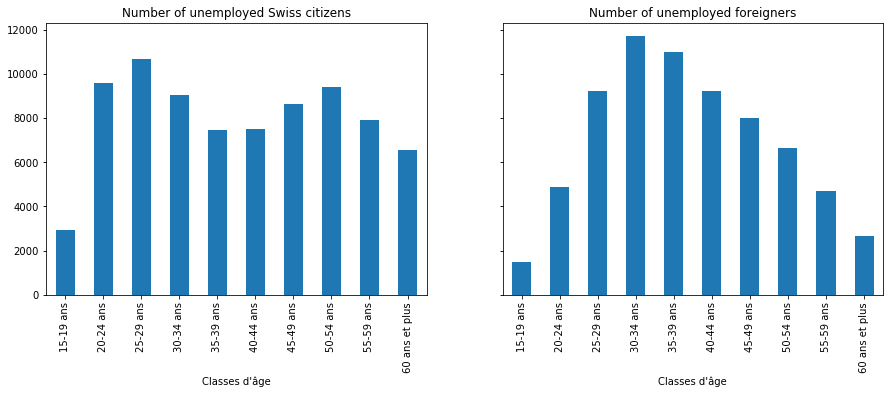

In [115]:
# Separate the data between Swiss people and foreigners
un_sw = un_for_age_yr[un_for_age_yr['Nationalité'] == 'Suisses'].drop('Nationalité', axis=1).set_index('Classes d\'âge')
un_for = un_for_age_yr[un_for_age_yr['Nationalité'] == 'Etrangers'].drop('Nationalité', axis=1).set_index('Classes d\'âge')

# Display two bar plots
fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True)
un_sw.plot(kind='bar', ax=axes[0], title="Number of unemployed Swiss citizens", figsize=(8, 8), legend=None)

un_for.plot(kind='bar', ax=axes[1], title="Number of unemployed foreigners", figsize=(15, 5), legend=None)
plt.show()

# Question 4 (Bonus)

By reusing the data from the previous questions, we can give a rough estimate of the average unemployment rate of both sides of the Röstigraben, i.e. the French-speaking and German-speaking parts of Switzerland. To do so, we compute the average of the Cantons that are part of "Suisse Romande" (GE, VD, NE, VS, FR, JU), eventhough some are bilingual - hence the "rough" estimate - and compute the average between the other Cantons of "Suisse Allemande". We also display the unmeployment rate of Ticino separetely as it is not on either side of the Röstigraben.

The data from amstat conveniently categorizes unemployment by linguistic region, but Ticino is grouped with the French part, so we still have to separate it.

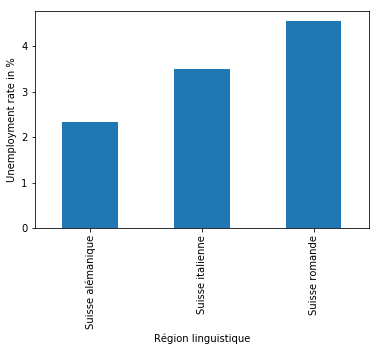

In [8]:
# Get data and group by region
sw_un_data = pd.read_csv(SW_UN_DATA_PATH)
sw_un_data.loc[sw_un_data.Canton == 'TI', 'Région linguistique'] = 'Suisse italienne'
sw_un_data.loc[sw_un_data['Région linguistique'] == 'Suisse romande et Tessin', 'Région linguistique'] = 'Suisse romande'
unemploy_by_region = sw_un_data.groupby(by='Région linguistique')['Taux de chômage'].mean()

# Display bar plot
unemploy_by_region.plot(kind='bar')
plt.ylabel('Unemployment rate in %')
plt.show()